In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


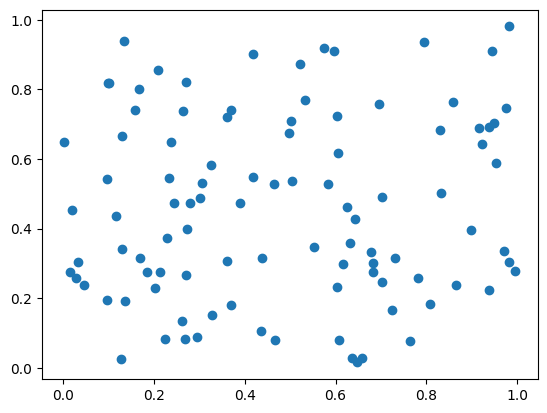

In [2]:
real_data = np.random.rand(100, 2)
real_data = pd.DataFrame(real_data, columns=['x', 'y'])
# plot real data
plt.scatter(real_data['x'], real_data['y'], label='real data')

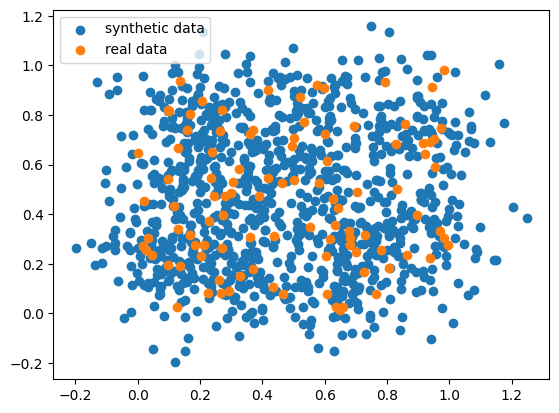

In [5]:


def generate_synthetic_data(
    real_data,
    n_samples=1000,
    fidelity=0.1,
):
    # generate synthetic data
    synthetic_data = real_data.sample(n_samples, replace=True)
    for col in synthetic_data.columns:
        noise = np.random.normal(0, fidelity, n_samples)
        synthetic_data[col] += noise
    return synthetic_data
example_data = generate_synthetic_data(real_data)
# plot synthetic data
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.legend()

In [6]:
import ipywidgets as widgets
from ipywidgets import interact

@interact(fidelity=widgets.FloatSlider(min=0.0, max=1.0, step=0.1, value=0.1))
def plot_synthetic_data(fidelity):
    example_data = generate_synthetic_data(real_data, fidelity=fidelity)
    plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
    plt.scatter(real_data['x'], real_data['y'], label='real data')
    plt.legend()
    plt.show()


ModuleNotFoundError: No module named 'ipywidgets'

In [7]:
# TODO: Find the method of identifying outliers in the synthetic data

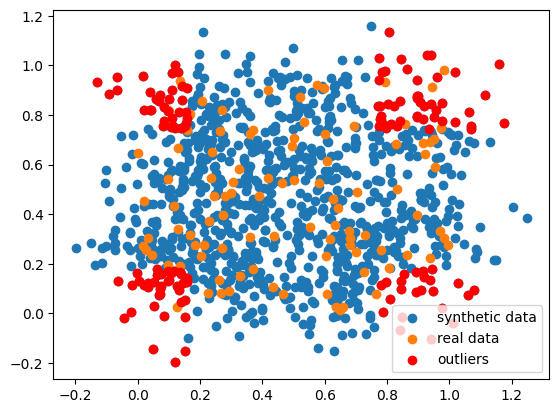

In [15]:
# Circle all outliers in the synthetic data
def identify_outliers(data):
    # calculate the mean and standard deviation of the data
    mean = data.mean()
    std = data.std()
    # calculate the z-score of the data
    z_score = (data - mean) / std
    # identify the outliers
    outliers = z_score.abs() > 1
    return outliers
example_outliers = identify_outliers(example_data)
# plot outliers
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.scatter(example_data[example_outliers]['x'], example_data[example_outliers]['y'], label='outliers', color='red')
plt.legend()

y
0.46216342104800406 0.2807590482569658
x
0.46394642202157094 0.30535223761478364


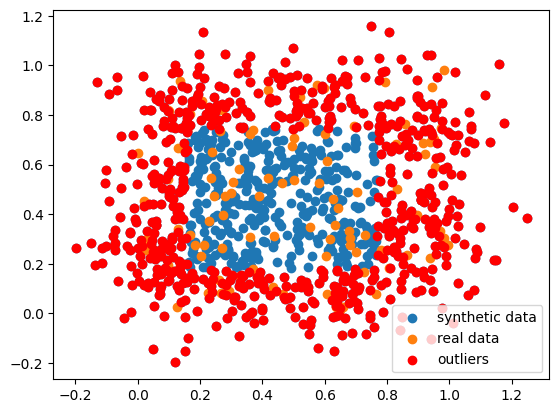

In [36]:
# Circle all outliers in the synthetic data
def identify_outliers_per_variable(data, distance=1):
    # TODO: This is a WIP
    # calculate the mean and standard deviation of the data
    outliers_full = pd.Series(False, index=data.index)
    for col in reversed(data.columns):
        mean = data[col].mean()
        std = data[col].std()
        # calculate the z-score of the data
        z_score = (data[col] - mean) / std
        # identify the outliers
        outliers = z_score.abs() > distance
        outliers_full = outliers_full | outliers
    return outliers_full
example_outliers = identify_outliers_per_variable(example_data)


# plot outliers
plt.scatter(example_data['x'], example_data['y'], label='synthetic data')
plt.scatter(real_data['x'], real_data['y'], label='real data')
plt.scatter(example_data[example_outliers]['x'], example_data[example_outliers]['y'], label='outliers', color='red')
plt.legend()